<a href="https://colab.research.google.com/github/vinodthadi29/CODSOFT/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.optimizers import Adam
import joblib

In [3]:
!ls /content/fraudTrain
!ls /content/fraudTest

ls: cannot access '/content/fraudTrain': No such file or directory
ls: cannot access '/content/fraudTest': No such file or directory


In [12]:
!unzip /content/fraudTrain.csv.zip -d /content/fraudTrain *.csv
!unzip /content/fraudTest.csv.zip -d /content/fraudTest *.csv

Archive:  /content/fraudTrain.csv.zip
  inflating: /content/fraudTrain/fraudTrain.csv  
Archive:  /content/fraudTest.csv.zip
replace /content/fraudTest/fraudTest.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/fraudTest/fraudTest.csv  


In [26]:
# Verify the path using !ls /content/fraudTrain after unzip
train_data = pd.read_csv('/content/fraudTrain/fraudTrain.csv')  # Adjust the path if needed

# Update the path for test data as well, using !ls /content/fraudTest
test_data = pd.read_csv('/content/fraudTest/fraudTest.csv')  # Adjust the path if needed

In [27]:
# Combine both train and test data to facilitate preprocessing
data = pd.concat([train_data, test_data], ignore_index=True)

In [15]:
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [16]:
data.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,5.371934e+05,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03
std,3.669110e+05,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00
25%,2.315490e+05,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00
50%,4.630980e+05,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00
75%,8.335758e+05,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [18]:
# Print column names to check if 'Class' exists
print("Columns in dataset:", data.columns)

Columns in dataset: Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [19]:
data.isnull()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1852390,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1852391,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1852392,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
data.duplicated().sum()

0

In [21]:
# Remove duplicates if present
data.drop_duplicates(inplace=True)

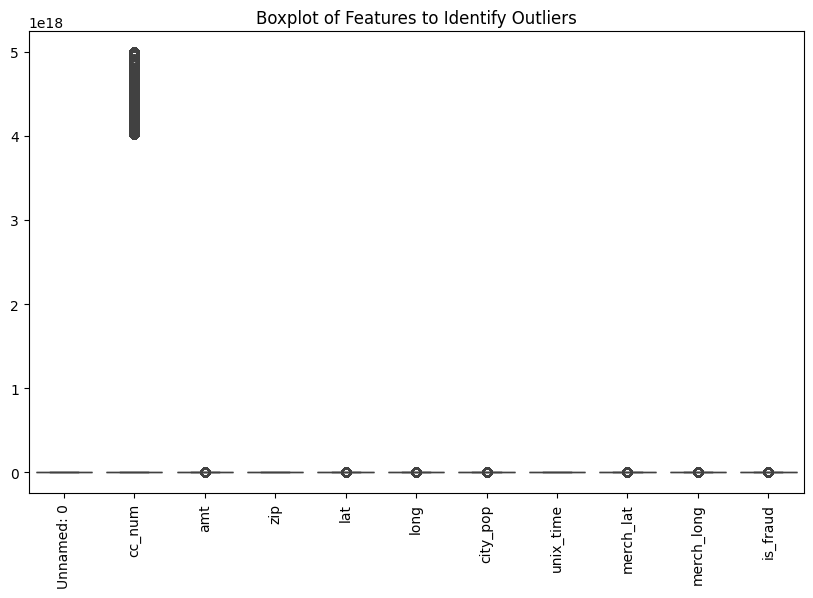

In [22]:
# Handling missing values by filling them with the median value (for numerical columns)
numerical_features = data.select_dtypes(include=np.number).columns
data[numerical_features] = data[numerical_features].fillna(data[numerical_features].median())

# Visualizing outliers through a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[numerical_features])
plt.title('Boxplot of Features to Identify Outliers')
plt.xticks(rotation=90)
plt.show()

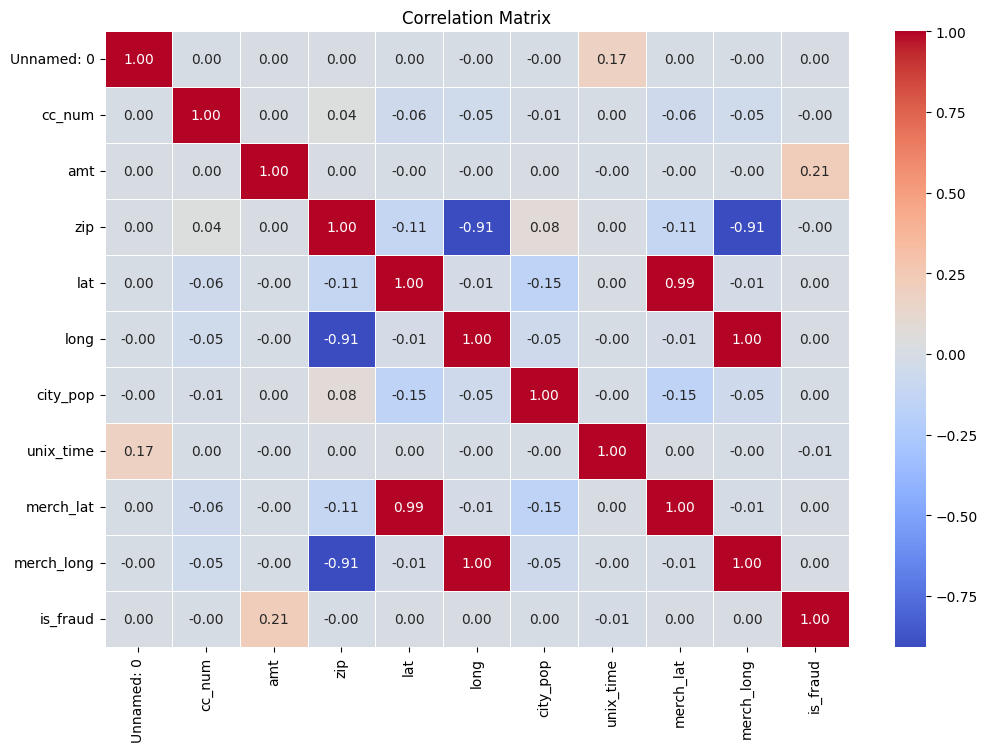

In [23]:
# Perform feature correlation analysis
correlation_matrix = data[numerical_features].corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [24]:
# Select only numeric columns for variance calculation
data_numeric = data.select_dtypes(include=[np.number])

# Find features with very low variance
low_variance_threshold = 0.01
low_variance_features = [col for col in data_numeric.columns if data_numeric[col].var() < low_variance_threshold]

# Drop the low variance features from the original data (including non-numeric columns)
data.drop(columns=low_variance_features, inplace=True)

print(f"Dropped Low Variance Features: {low_variance_features}")

Dropped Low Variance Features: ['is_fraud']


In [28]:
# Check if any column contains fraud-related information
fraud_columns = [col for col in data.columns if 'fraud' in col.lower()]
print(fraud_columns)

['is_fraud']


In [29]:
# Check for duplicate column names (if any)
duplicates = data.columns[data.columns.duplicated()]
print(duplicates)

Index([], dtype='object')


In [30]:
# Strip spaces from column names
data.columns = data.columns.str.strip()

# Now, try to drop the 'is_fraud' column again
columns_to_drop = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'trans_num', 'unix_time']

# Check if 'is_fraud' column exists
if 'is_fraud' in data.columns:
    columns_to_drop.append('is_fraud')

X = data.drop(columns=columns_to_drop, axis=1)  # Drop irrelevant columns
y = data['is_fraud']  # Target variable

In [31]:
# Separate features (X) and target variable (y)
# Check if 'Class' column exists before dropping it
if 'Class' in data.columns:
    X = data.drop('Class', axis=1)
    y = data['Class']
else:
    # Handle the case where 'Class' column is not found
    # You might need to investigate why it's missing or use a different target column
    print("Column 'Class' not found in the DataFrame.")
    # ... (add your logic to handle the missing column)
    # For example, you can print the available columns to see if there's a similar column
    print("Available columns:", data.columns)

# If 'Class' column is not found and you want to use a different target column, assign it to y
# For example, if 'isFraud' is your target column:
# y = data['isFraud']

Column 'Class' not found in the DataFrame.
Available columns: Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [32]:


# Select only numeric columns for PCA
X_numeric = X.select_dtypes(include=[np.number])

# Use PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_numeric)

print(f"Reduced to {X_pca.shape[1]} components using PCA")

Reduced to 1 components using PCA


Explained variance ratio for each component: [0.99216008]
Cumulative explained variance: [0.99216008]


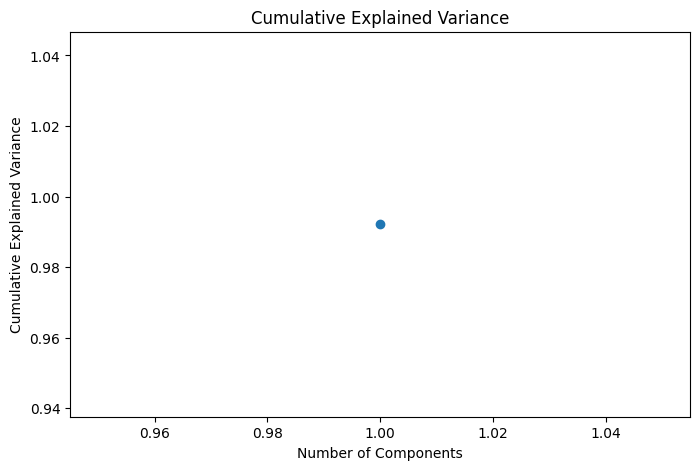

In [33]:
# Check explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(f"Explained variance ratio for each component: {explained_variance}")
print(f"Cumulative explained variance: {cumulative_variance}")

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

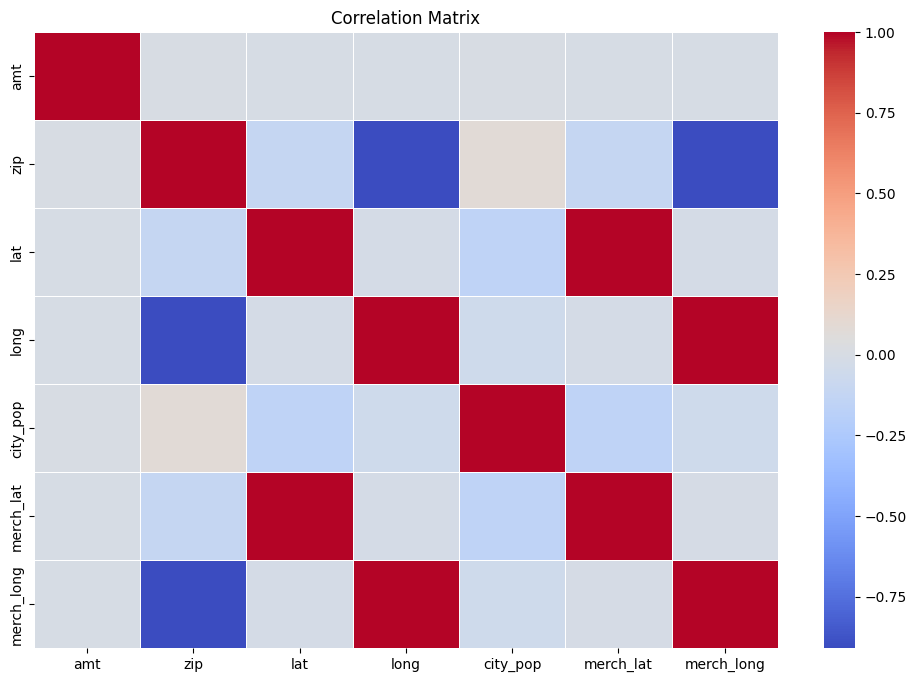

In [34]:
correlation_matrix = X_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [35]:
# Choose a fixed number of components
pca = PCA(n_components=5)  # Keep top 5 components
X_pca = pca.fit_transform(X_numeric)
print(f"Reduced to {X_pca.shape[1]} components using PCA")

Reduced to 5 components using PCA


In [36]:
# Apply StandardScaler to normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

In [37]:
# Apply SMOTE to address class imbalance by over-sampling the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [38]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [39]:
# Initialize the machine learning models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

In [40]:
# Store results in a dictionary
results = {}

# Import the time module
import time

# Start the clock before training
start_time = time.time()

# Use a smaller subset of the data
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)
X_test_sub, _, y_test_sub, _ = train_test_split(X_test, y_test, train_size=0.1, random_state=42)

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train_sub, y_train_sub)  # Train on the smaller subset
    y_pred = model.predict(X_test_sub)  # Predict on the smaller test set
    y_pred_prob = model.predict_proba(X_test_sub)[:, 1]  # Get probabilities for ROC-AUC

    # Store results
    results[model_name] = {
        'Classification Report': classification_report(y_test_sub, y_pred),
        'ROC-AUC': roc_auc_score(y_test_sub, y_pred_prob)
    }

# Stop the clock after training
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

# Print the results of each model
for model_name, result in results.items():
    print(f"Results for {model_name}:")
    print(result['Classification Report'])
    print(f"ROC-AUC: {result['ROC-AUC']}")

Total execution time: 190.53 seconds
Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87     36761
           1       0.94      0.76      0.84     36948

    accuracy                           0.86     73709
   macro avg       0.87      0.86      0.86     73709
weighted avg       0.87      0.86      0.86     73709

ROC-AUC: 0.831793667557996
Results for Decision Tree:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     36761
           1       0.95      0.95      0.95     36948

    accuracy                           0.95     73709
   macro avg       0.95      0.95      0.95     73709
weighted avg       0.95      0.95      0.95     73709

ROC-AUC: 0.9505408546827075
Results for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     36761
           1       0.97      0.98      0.97     36948

   

In [41]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Reduced parameter grid
param_grid_rf = {
    'n_estimators': [50],  # Even fewer trees to speed up
    'max_depth': [None],  # Keeping default depth
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}

# Use HalvingGridSearchCV, which progressively narrows down hyperparameter search space
halving_grid_search_rf = HalvingGridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=3,  # Use just 3-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,  # Use all available cores
    verbose=2,
    factor=2,  # Increase factor for faster convergence
    random_state=42
)

# Further reduce the dataset size for quicker results
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.05, random_state=42)  # 5% data

# Fit the Halving Grid Search model
halving_grid_search_rf.fit(X_train_sub, y_train_sub)

# Print the best hyperparameters found
print("Best Hyperparameters:", halving_grid_search_rf.best_params_)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 147419
max_resources_: 147419
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1
n_resources: 147419
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [42]:
# Evaluate the best Random Forest model
y_pred_rf = halving_grid_search_rf.predict(X_test)
y_pred_rf_prob = halving_grid_search_rf.predict_proba(X_test)[:, 1]

In [43]:
print("\nClassification Report (Best Random Forest):\n", classification_report(y_test, y_pred_rf))
print(f"ROC-AUC (Best Random Forest): {roc_auc_score(y_test, y_pred_rf_prob)}")


Classification Report (Best Random Forest):
               precision    recall  f1-score   support

           0       0.96      0.96      0.96    368549
           1       0.96      0.96      0.96    368549

    accuracy                           0.96    737098
   macro avg       0.96      0.96      0.96    737098
weighted avg       0.96      0.96      0.96    737098

ROC-AUC (Best Random Forest): 0.9914136038149554


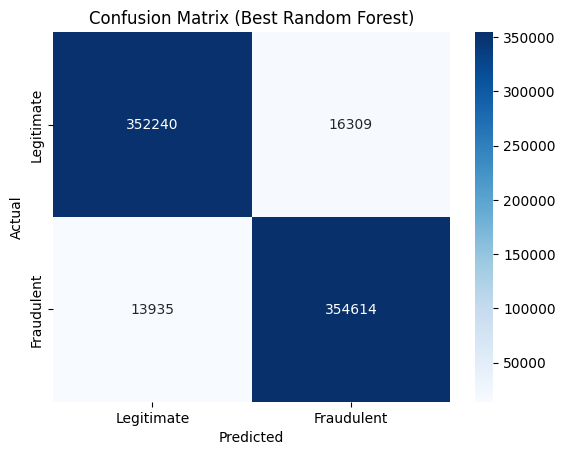

In [44]:
# Plot the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.title("Confusion Matrix (Best Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [45]:
# Plot Precision-Recall and ROC Curves
precision, recall, _ = precision_recall_curve(y_test, y_pred_rf_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_rf_prob)

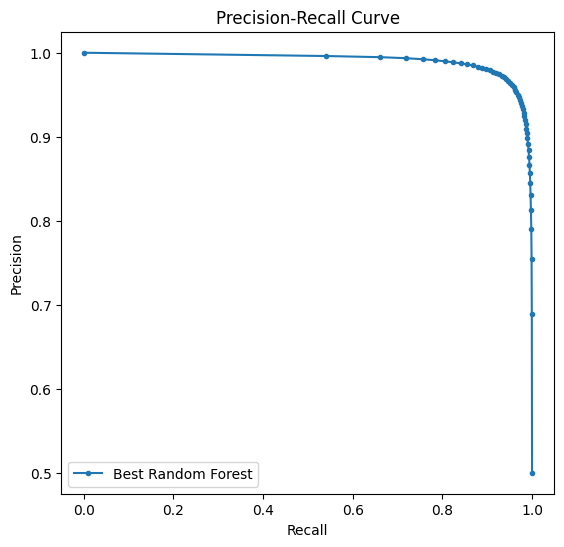

In [46]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.', label='Best Random Forest')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

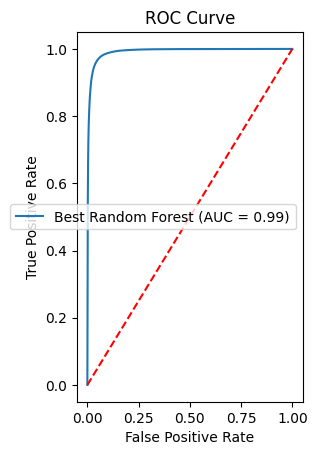

In [47]:
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'Best Random Forest (AUC = {roc_auc_score(y_test, y_pred_rf_prob):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [48]:
# Save the best Random Forest model for future use
joblib.dump(halving_grid_search_rf, 'fraud_detection_model.pkl')
print("Best Random Forest model saved as fraud_detection_model.pkl")

Best Random Forest model saved as fraud_detection_model.pkl


In [49]:
# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

In [50]:
!pip install --upgrade scikit-learn

In [51]:

from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping

# Define the Autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 4)  # Reduced encoding dimension

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Use a smaller subset of the data
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

# Train the Autoencoder with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
autoencoder.fit(X_train_sub, X_train_sub, epochs=20, batch_size=128, shuffle=True, validation_split=0.2, callbacks=[early_stopping])

# Calculate reconstruction errors for the test data
X_test_pred = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - X_test_pred), axis=1)

# Set a threshold for fraud detection based on the 95th percentile of reconstruction error
threshold = np.percentile(reconstruction_errors, 95)
print(f"Threshold for fraud detection: {threshold}")

Epoch 1/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.1179 - val_loss: 1.8185
Epoch 2/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 1.8605 - val_loss: 1.7621
Epoch 3/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 1.7864 - val_loss: 1.7364
Epoch 4/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.7991 - val_loss: 1.7215
Epoch 5/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.7810 - val_loss: 1.7140
Epoch 6/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.7520 - val_loss: 1.7102
Epoch 7/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.7461 - val_loss: 1.7082
Epoch 8/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.7539 - val_loss: 1.7068
Epoch 9/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.7550 - val_loss: 1.7059
Epoch 10/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.7614 - val_loss: 1.7052
Epoch 11/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.8040 - val_loss: 1.7047
Epoch 12/20
1843/1843 ━━━━━

In [52]:
# Classify fraud based on reconstruction error threshold
y_pred_autoencoder = (reconstruction_errors > threshold).astype(int)

# Evaluate the Autoencoder model
print("\nAutoencoder Classification Report:\n", classification_report(y_test, y_pred_autoencoder))
print(f"ROC-AUC (Autoencoder): {roc_auc_score(y_test, reconstruction_errors)}")


Autoencoder Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.99      0.68    368549
           1       0.89      0.09      0.16    368549

    accuracy                           0.54    737098
   macro avg       0.71      0.54      0.42    737098
weighted avg       0.71      0.54      0.42    737098

ROC-AUC (Autoencoder): 0.7511030136658694


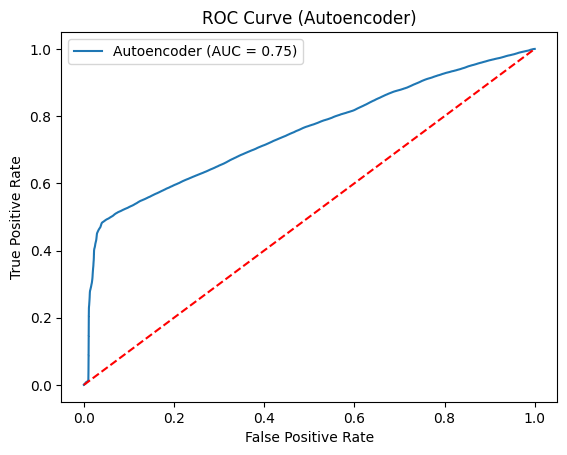

In [53]:
# Plot ROC Curve for the Autoencoder
fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)
plt.plot(fpr, tpr, label=f'Autoencoder (AUC = {roc_auc_score(y_test, reconstruction_errors):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title('ROC Curve (Autoencoder)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [54]:
# Reshape the data for LSTM
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

In [55]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [56]:
# Build the LSTM model
lstm_model = tf.keras.Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=2, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/2
18524/18524 ━━━━━━━━━━━━━━━━━━━━ 107s 6ms/step - accuracy: 0.9941 - loss: 0.0404 - val_accuracy: 0.9947 - val_loss: 0.0220
Epoch 2/2
18524/18524 ━━━━━━━━━━━━━━━━━━━━ 140s 5ms/step - accuracy: 0.9948 - loss: 0.0213 - val_accuracy: 0.9948 - val_loss: 0.0192


In [58]:
# Evaluate the LSTM model
y_pred_lstm = lstm_model.predict(X_test).ravel()
y_pred_lstm_class = (y_pred_lstm > 0.5).astype(int)
print("\nLSTM Classification Report:\n", classification_report(y_test, y_pred_lstm_class))
print(f"ROC-AUC (LSTM): {roc_auc_score(y_test, y_pred_lstm)}")

11578/11578 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step

LSTM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.62      0.11      0.19      1953

    accuracy                           0.99    370479
   macro avg       0.81      0.56      0.59    370479
weighted avg       0.99      0.99      0.99    370479

ROC-AUC (LSTM): 0.911709494998493


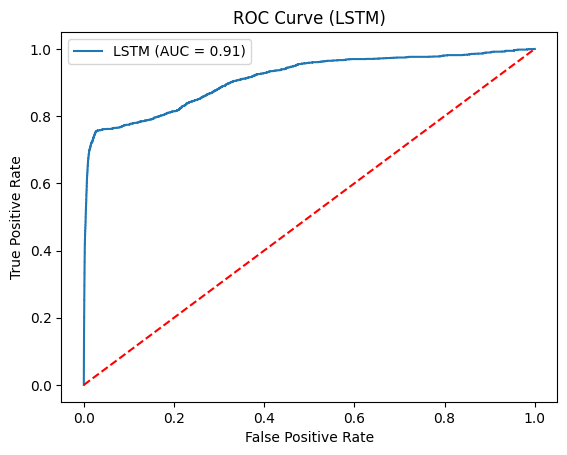

In [59]:
# Plot the ROC Curve for the LSTM model
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm)
plt.plot(fpr, tpr, label=f'LSTM (AUC = {roc_auc_score(y_test, y_pred_lstm):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title('ROC Curve (LSTM)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [60]:
# Save the LSTM model
lstm_model.save('lstm_fraud_detection_model.h5')
print("LSTM Model saved as lstm_fraud_detection_model.h5")

LSTM Model saved as lstm_fraud_detection_model.h5


In [63]:
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Check if categorical columns exist before encoding
categorical_cols = ['category', 'merchant']  # Add more categorical columns if needed
categorical_cols_present = [col for col in categorical_cols if col in X.columns]

# Encode only the present categorical columns
for col in categorical_cols_present:
    le = LabelEncoder()
    X[col + '_encoded'] = le.fit_transform(X[col])
    X = X.drop(col, axis=1)  # Drop the original column

# Select only numeric features for scaling and training
numeric_features = X.select_dtypes(include=np.number).columns
X_numeric = X[numeric_features]

# Split the data into training and testing sets (if not already done)
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Apply StandardScaler to the numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reduce number of estimators and use all available CPU cores
rf_model = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [64]:
import joblib

# Save the Random Forest model
joblib.dump(model, 'fraud_detection_model.pkl')
print("Random Forest model saved as 'fraud_detection_model.pkl'")

Random Forest model saved as 'fraud_detection_model.pkl'


In [66]:
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

Scaler saved as 'scaler.pkl'


In [67]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Load Random Forest model
rf_model = joblib.load('fraud_detection_model.pkl')

# Load Autoencoder with custom objects
custom_objects = {"mse": MeanSquaredError()}
autoencoder_model = load_model('autoencoder_fraud_detection_model.h5', custom_objects=custom_objects)

# Recompile the autoencoder model
autoencoder_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Load LSTM model
lstm_model = load_model('lstm_fraud_detection_model.h5')

# Load scaler
scaler = joblib.load('scaler.pkl')

In [68]:
# Save with custom objects (during training)
autoencoder.save('autoencoder_fraud_detection_model.h5', include_optimizer=True)

# Load with the same custom objects
autoencoder_model = load_model('autoencoder_fraud_detection_model.h5', custom_objects={'mse': 'mse'})

In [69]:
import h5py

with h5py.File('autoencoder_fraud_detection_model.h5', 'r') as f:
    print(f.attrs['training_config'])

{"loss": "mse", "loss_weights": null, "metrics": null, "weighted_metrics": null, "run_eagerly": false, "steps_per_execution": 1, "jit_compile": false, "optimizer_config": {"class_name": "Adam", "config": {"name": "adam", "learning_rate": 0.0010000000474974513, "weight_decay": null, "clipnorm": null, "global_clipnorm": null, "clipvalue": null, "use_ema": false, "ema_momentum": 0.99, "ema_overwrite_frequency": null, "loss_scale_factor": null, "gradient_accumulation_steps": null, "beta_1": 0.9, "beta_2": 0.999, "epsilon": 1e-07, "amsgrad": false}}}


In [72]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

# Define numeric and categorical columns
numeric_features = ['amt']
categorical_features = ['category', 'merchant']

# Define preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Sample training data
data = pd.DataFrame({
    'amt': [100.0, 200.0, 150.0],
    'category': ['food', 'entertainment', 'food'],
    'merchant': ['merchant_1', 'merchant_2', 'merchant_1'],
    'is_fraud': [0, 1, 0]
})

# Separate features and target
X = data[['amt', 'category', 'merchant']]
y = data['is_fraud']

# Apply preprocessing
preprocessor.fit(X)
X_processed = preprocessor.transform(X)

# Debugging: Check feature dimensions
print("Feature dimensions after preprocessing (training):", X_processed.shape)

# Train Random Forest
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Save model and preprocessor
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Model and preprocessor saved successfully!")

Feature dimensions after preprocessing (training): (3, 5)
Model and preprocessor saved successfully!


In [74]:
print("Columns used in preprocessor:", numeric_features + categorical_features)

Columns used in preprocessor: ['amt', 'category', 'merchant']


In [75]:
import json

def predict_fraud(file):
    try:
        # Read the uploaded file
        data = pd.read_csv(file)
        print(f"Data loaded successfully. Shape of data: {data.shape}")

        # Preprocessing
        data.fillna(data.median(), inplace=True)  # Handle missing values
        low_variance_threshold = 0.01
        low_variance_features = [col for col in data.columns if data[col].var() < low_variance_threshold]
        data.drop(columns=low_variance_features, inplace=True)  # Drop low variance columns
        print(f"Data after low variance columns removal: {data.shape}")

        # Separate features and target
        X = data.drop('Class', axis=1)
        y = data['Class']

        # PCA for dimensionality reduction
        pca = PCA(n_components=0.95)
        X_pca = pca.fit_transform(X)
        print(f"Data after PCA: {X_pca.shape}")

        # Scale features using StandardScaler
        X_scaled = scaler.transform(X_pca)
        print(f"Data after scaling: {X_scaled.shape}")

        # SMOTE for balancing the dataset
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
        print(f"Data after SMOTE: {X_resampled.shape}")

        # Random Forest Predictions
        rf_pred = rf_model.predict(X_resampled)
        rf_prob = rf_model.predict_proba(X_resampled)[:, 1]
        rf_auc = roc_auc_score(y_resampled, rf_prob)

        # Autoencoder Predictions
        X_test_pred = autoencoder_model.predict(X_scaled)
        reconstruction_errors = np.mean(np.square(X_scaled - X_test_pred), axis=1)
        threshold = np.percentile(reconstruction_errors, 95)
        y_pred_autoencoder = (reconstruction_errors > threshold).astype(int)

        # LSTM Predictions
        X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
        y_pred_lstm = lstm_model.predict(X_reshaped).ravel()
        y_pred_lstm_class = (y_pred_lstm > 0.5).astype(int)

        # Create a result dictionary
        results = {
            "Random Forest ROC-AUC": rf_auc,
            "Autoencoder Threshold": threshold,
            "LSTM Predictions": y_pred_lstm_class.tolist()  # Ensure the predictions are in list format
        }

        # Convert the result dictionary to a JSON string
        results_json = json.dumps(results)

        # Generate plots
        # Confusion Matrix for Random Forest
        cm_rf = confusion_matrix(y_resampled, rf_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
        plt.title("Confusion Matrix (Random Forest)")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        cm_plot_path = "confusion_matrix.png"
        plt.savefig(cm_plot_path)
        plt.close()

        # ROC Curve for Random Forest
        fpr, tpr, _ = roc_curve(y_resampled, rf_prob)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='red')
        plt.title('ROC Curve (Random Forest)')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        roc_plot_path = "roc_curve.png"
        plt.savefig(roc_plot_path)
        plt.close()

        # Return results and plots
        return results_json, cm_plot_path, roc_plot_path
    except Exception as e:
        return str(e), None, None

In [77]:
%%writefile credit_card_transactions.csv
amt,category,merchant,is_fraud
100.0,groceries,supermarket,0
500.0,electronics,online_store,1
20.0,transport,ride_share,0
1000.0,travel,airline,1
50.0,restaurant,local_restaurant,0
200.0,electronics,online_store,1
10.0,groceries,supermarket,0
1500.0,travel,airline,1
30.0,transport,ride_share,0
75.0,restaurant,local_restaurant,0

Writing credit_card_transactions.csv


In [78]:
pip install pandas numpy joblib keras matplotlib scikit-learn gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.1/464.1 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.27.1
    Uninstalling huggingface-hub-0.27.1:
      Successfully uninstalled huggingface-hub-0.27.1


In [79]:
%%writefile app.py
import gradio as gr
import pandas as pd
import numpy as np
import joblib
from keras.models import load_model
from keras.losses import MeanSquaredError
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import os

# Load Models and Preprocessor
rf_model = joblib.load("random_forest_model.pkl")
autoencoder_model = load_model("autoencoder_fraud_detection_model.h5", custom_objects={"mse": MeanSquaredError()})
preprocessor = joblib.load("preprocessor.pkl")

# Function to process input data
def process_input(file):
    try:
        # Read the uploaded CSV file
        data = pd.read_csv(file.name)

        # Required columns
        required_columns = ["amt", "category", "merchant"]

        # Check if required columns exist
        if not all(col in data.columns for col in required_columns):
            return None, None, f"Error: Required columns not found. Columns provided: {list(data.columns)}"

        # Handle missing values
        if data.isnull().values.any():
            data = data.dropna()  # Drop rows with missing values
            if data.empty:
                return None, None, "Error: All rows were removed due to missing values."

        # Preprocess input data
        X = data[required_columns]
        X_processed = preprocessor.transform(X)

        # Check for target column if available
        y = data.get("is_fraud", None)

        return X_processed, y, None
    except Exception as e:
        return None, None, f"Error processing file: {str(e)}"

# Function to make predictions and generate outputs
def make_prediction(file):
    # Process the uploaded file
    X_processed, y, error = process_input(file)
    if error:
        return error, None, None, None

    try:
        # Predictions from Random Forest
        rf_pred = rf_model.predict(X_processed)

        # Autoencoder prediction for anomaly detection
        autoencoder_pred = autoencoder_model.predict(X_processed)
        mse = np.mean(np.square(X_processed - autoencoder_pred), axis=1)

        # Dynamic thresholding for anomaly detection
        threshold = np.percentile(mse, 95)  # Use 95th percentile as the threshold
        autoencoder_pred_class = (mse > threshold).astype(int)

        # Combine results from both models (ensemble)
        combined_pred = (rf_pred | autoencoder_pred_class)

        # Save results for download
        results = pd.DataFrame({
            "Transaction_ID": range(len(combined_pred)),
            "RF_Prediction": rf_pred,
            "Autoencoder_Score": mse,
            "Autoencoder_Prediction": autoencoder_pred_class,
            "Final_Prediction": combined_pred
        })
        results_file = "predictions.csv"
        results.to_csv(results_file, index=False)

        # If true labels are available, calculate metrics
        if y is not None:
            cm = confusion_matrix(y, combined_pred)
            fpr, tpr, _ = roc_curve(y, combined_pred)
            roc_auc = auc(fpr, tpr)

            # Precision-Recall Curve
            precision, recall, _ = precision_recall_curve(y, combined_pred)

            # Classification Report
            report = classification_report(y, combined_pred, output_dict=True)
            precision_score = report["1"]["precision"]
            recall_score = report["1"]["recall"]
            f1_score = report["1"]["f1-score"]

            # Create Confusion Matrix and ROC Curve Plots
            fig_cm, ax_cm = plt.subplots()
            ax_cm.matshow(cm, cmap=plt.cm.Blues)
            plt.title("Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.colorbar(ax_cm.matshow(cm, cmap=plt.cm.Blues))
            plt.close(fig_cm)

            fig_roc, ax_roc = plt.subplots()
            ax_roc.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
            ax_roc.plot([0, 1], [0, 1], linestyle="--", color="gray")
            ax_roc.set_title("ROC Curve")
            ax_roc.set_xlabel("False Positive Rate")
            ax_roc.set_ylabel("True Positive Rate")
            ax_roc.legend(loc="lower right")
            plt.close(fig_roc)

            # Create Precision-Recall Curve Plot
            fig_pr, ax_pr = plt.subplots()
            ax_pr.plot(recall, precision, label="Precision-Recall Curve", color="green")
            ax_pr.set_title("Precision-Recall Curve")
            ax_pr.set_xlabel("Recall")
            ax_pr.set_ylabel("Precision")
            ax_pr.legend(loc="lower left")
            plt.close(fig_pr)

            metrics = (f"Precision: {precision_score:.2f}, Recall: {recall_score:.2f}, F1-Score: {f1_score:.2f}")
            return metrics, results_file, fig_cm, fig_roc, fig_pr
        else:
            # If no true labels, just provide prediction results
            return "Prediction complete! Results saved.", results_file, None, None, None
    except Exception as e:
        return f"Error during prediction: {str(e)}", None, None, None, None

# Gradio Interface
iface = gr.Interface(
    fn=make_prediction,
    inputs=gr.File(label="Upload CSV File"),
    outputs=[
        gr.Textbox(label="Metrics/Result"),
        gr.File(label="Download Predictions"),
        gr.Plot(label="Confusion Matrix"),
        gr.Plot(label="ROC Curve"),
        gr.Plot(label="Precision-Recall Curve")
    ],
    title="Enhanced Credit Card Fraud Detection",
    description=(
        "Upload a CSV file with transaction data to detect fraudulent activities using Random Forest and Autoencoder models. "
        "Get detailed metrics, plots, and downloadable results."
    )
)

# Launch Gradio Interface
iface.launch(share=True)

Writing app.py


In [80]:
!python app.py

2025-02-06 11:16:50.952884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738840610.999918    7625 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738840611.014118    7625 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 11:16:58.777188: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://1867b7c6a7348da80e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working director